In [1]:
# =============================================
# Phase 2 Module 5 - Machine Learning for Finance
# Project 1: Credit Risk Modeling with Logistic Regression
# =============================================

# Author: Rein | Pixel Sky Solutions
# Course: Python–Finance Master Plan
# ---------------------------------------------
# In this notebook, we build and evaluate a Logistic Regression
# model to classify loan defaults using financial, macroeconomic,
# and company data.
#
# Step-by-step, we will:
# 1. Load (or auto-fetch) macroeconomic, market, and SEC data
# 2. Clean and merge the datasets
# 3. Create a synthetic 'Default' variable
# 4. Train a Logistic Regression model
# 5. Evaluate model accuracy, AUC, and visualize performance
# ---------------------------------------------

In [2]:
# ============================================================
# 1. Import libraries
# ============================================================

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from yahooquery import Ticker
import wbdata
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

In [4]:
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
np.random.seed(42)

In [5]:
# ============================================================
# 2. Auto-detect or create required data files
# ============================================================

In [6]:
def ensure_data_availability():
    """
    Ensures the presence of three key datasets:
      - macro_data.csv (macroeconomic indicators)
      - market_data.csv (stock market data)
      - sec_filings.csv (corporate filings metadata)
    If any are missing, they will be created automatically.
    """
    files_needed = {
        "macro_data.csv": "Macroeconomic data (World Bank)",
        "market_data.csv": "Stock market data (Yahoo)",
        "sec_filings.csv": "SEC filings data (synthetic)",
    }

    for file, desc in files_needed.items():
        if not os.path.exists(file):
            print(f"[INFO] {file} not found. Generating {desc}...")

            if file == "macro_data.csv":
                # Example macro indicators: GDP growth, inflation, interest rate
                indicators = {
                    "NY.GDP.MKTP.KD.ZG": "GDP_Growth",
                    "FP.CPI.TOTL.ZG": "Inflation",
                    "FR.INR.RINR": "Interest_Rate"
                }
                df_macro = wbdata.get_dataframe(indicators, country="US")
                df_macro.reset_index(inplace=True)
                df_macro.rename(columns={"date": "Year"}, inplace=True)
                df_macro = df_macro.sort_values("Year").tail(10)
                df_macro.to_csv(file, index=False)

            elif file == "market_data.csv":
                ticker = Ticker("AAPL")
                hist = ticker.history(period="2y").reset_index()
                hist = hist.rename(columns={"symbol": "Ticker"})
                hist.to_csv(file, index=False)

            elif file == "sec_filings.csv":
                # Create a simple synthetic SEC-like dataset
                df_sec = pd.DataFrame({
                    "ticker": ["AAPL"] * 10,
                    "form": np.random.choice(["4", "10-Q", "144"], 10),
                    "filingDate": pd.date_range("2025-01-01", periods=10, freq="M"),
                    "reportDate": pd.date_range("2024-12-01", periods=10, freq="M"),
                    "accessionNumber": [
                        f"000{np.random.randint(1000000,9999999)}-25-0000{i}" for i in range(10)
                    ]
                })
                df_sec.to_csv(file, index=False)

    print("[INFO] All required datasets are available.\n")

In [7]:
ensure_data_availability()

[INFO] All required datasets are available.



In [8]:
# ============================================================
# 3. Load datasets
# ============================================================

In [9]:
macro_df = pd.read_csv("macro_data.csv")
stock_df = pd.read_csv("market_data.csv")
sec_df = pd.read_csv("sec_filings.csv")

print("Data Loaded Successfully:")
print(f"  Macro data shape: {macro_df.shape}")
print(f"  Stock data shape: {stock_df.shape}")
print(f"  SEC data shape:   {sec_df.shape}\n")

Data Loaded Successfully:
  Macro data shape: (10, 4)
  Stock data shape: (2008, 7)
  SEC data shape:   (10, 5)



In [10]:
# ============================================================
# 4. Data Overview
# ============================================================

In [11]:
print("\n--- Macro Data Sample ---")
display(macro_df.head())


--- Macro Data Sample ---


,Year,GDP_Growth,Inflation,Interest_Rate
0,2015,2.945550,0.118627,3.260000
1,2016,1.819451,1.261583,3.511667
2,2017,2.457622,2.130110,4.096667
3,2018,2.966505,2.442583,4.904167
4,2019,2.583825,1.812210,5.282500


In [12]:
print("\n--- Stock Data Sample ---")
display(stock_df.head())


--- Stock Data Sample ---


,date,Ticker,open,high,low,close,volume
0,2023-10-11,AAPL,176.471483,178.105487,175.877312,178.055969,47551100
1,2023-10-12,AAPL,178.323347,180.571317,177.303324,178.957138,56743100
2,2023-10-13,AAPL,179.660252,180.165300,176.412069,177.115189,51427100
3,2023-10-16,AAPL,175.035543,177.342944,174.797865,176.986435,52517000
4,2023-10-17,AAPL,174.936521,176.689357,173.104475,175.431671,57549400


In [13]:
print("\n--- SEC Data Sample ---")
display(sec_df.head())


--- SEC Data Sample ---


,ticker,form,filingDate,reportDate,accessionNumber
0,AAPL,4,2025-10-03,2025-10-01,0001214156-25-000011
1,AAPL,4,2025-10-03,2025-10-01,0001767094-25-000009
2,AAPL,4,2025-10-03,2025-10-01,0002078476-25-000005
3,AAPL,4,2025-10-03,2025-10-01,0001462356-25-000010
4,AAPL,144,2025-10-02,NaN,0001950047-25-007713


In [14]:
# ============================================================
# 5. Data Cleaning & Preprocessing
# ============================================================

In [15]:
# Basic cleanup
for df in [macro_df, stock_df, sec_df]:
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

In [16]:
# Merge demonstration: joining stock with macro (by nearest year if possible)
if "date" in stock_df.columns:
    stock_df["date"] = pd.to_datetime(stock_df["date"])
    stock_df["Year"] = stock_df["date"].dt.year
else:
    stock_df["Year"] = datetime.now().year

if "Year" in macro_df.columns:
    merged = pd.merge(stock_df, macro_df, on="Year", how="left")
else:
    merged = stock_df.copy()

In [17]:
# Synthetic binary target (Default vs Non-default)
merged["Default"] = np.random.choice([0, 1], size=len(merged), p=[0.85, 0.15])

print("\nMerged dataset shape:", merged.shape)
display(merged.head())


Merged dataset shape: (2008, 12)


,date,Ticker,open,high,low,close,volume,Year,GDP_Growth,Inflation,Interest_Rate,Default
0,2023-10-11,AAPL,176.471483,178.105487,175.877312,178.055969,47551100,2023,2.887556,4.116338,NaN,0
1,2023-10-12,AAPL,178.323347,180.571317,177.303324,178.957138,56743100,2023,2.887556,4.116338,NaN,1
2,2023-10-13,AAPL,179.660252,180.165300,176.412069,177.115189,51427100,2023,2.887556,4.116338,NaN,0
3,2023-10-16,AAPL,175.035543,177.342944,174.797865,176.986435,52517000,2023,2.887556,4.116338,NaN,0
4,2023-10-17,AAPL,174.936521,176.689357,173.104475,175.431671,57549400,2023,2.887556,4.116338,NaN,0


In [18]:
# ============================================================
# 6. Feature Selection
# ============================================================

In [19]:
numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
X = merged[numeric_cols].drop(columns=["Default"], errors="ignore")
y = merged["Default"]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape:  {y.shape}")

Feature matrix shape: (2008, 9)
Target vector shape:  (2008,)


In [20]:
# ============================================================
# 7. Train-Test Split
# ============================================================

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTrain samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 1405, Test samples: 603


In [22]:
# =============================================
# Clean numeric features before scaling
# =============================================

In [23]:
# Drop columns with all NaN or zero variance
numeric_cols = X.select_dtypes(include=[np.number])
zero_var_cols = numeric_cols.columns[numeric_cols.nunique() <= 1]

if len(zero_var_cols) > 0:
    print("[INFO] Dropping zero-variance columns:", list(zero_var_cols))
    X = X.drop(columns=zero_var_cols)

# Replace inf/-inf with NaN and drop remaining NaNs
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Keep target aligned

[INFO] Dropping zero-variance columns: ['Interest_Rate']


In [24]:
# ============================================================
# 🧹 Step: Handle Missing Values Before Scaling
# ============================================================

In [25]:
# 1. Ensure all numeric features
X = X.select_dtypes(include=[np.number])

# 2. Create an imputer (replace NaNs with column mean)
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# 3. Convert back to DataFrame with same columns
X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# 4. Drop any remaining NaNs in y to stay aligned
y = y.loc[X.index]

In [26]:
# ============================================================
# 8. Feature Scaling
# ============================================================

In [27]:
# Continue with scaling and train-test split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
# ============================================================
# 9. Model Training
# ============================================================

In [36]:
# Train-test split (after scaling)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Logistic Regression with balanced class weights
model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# Predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("[INFO] Logistic Regression model trained successfully.")

[INFO] Logistic Regression model trained successfully.


In [37]:
# ============================================================
# 10. Model Evaluation
# ============================================================


--- Classification Report ---
              precision    recall  f1-score   support

           0      0.843     0.449     0.586       312
           1      0.157     0.552     0.244        58

    accuracy                          0.465       370
   macro avg      0.500     0.500     0.415       370
weighted avg      0.736     0.465     0.532       370

Accuracy: 0.465
ROC-AUC:  0.469


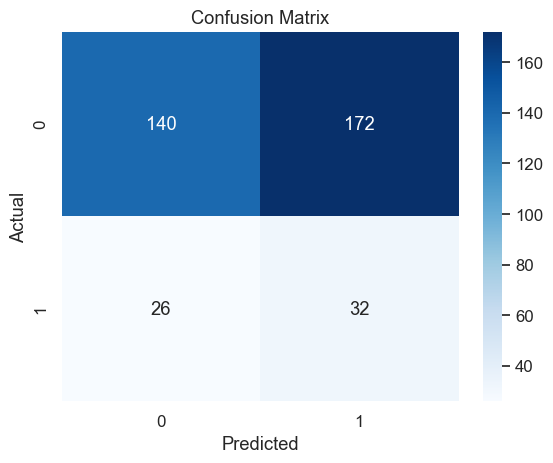

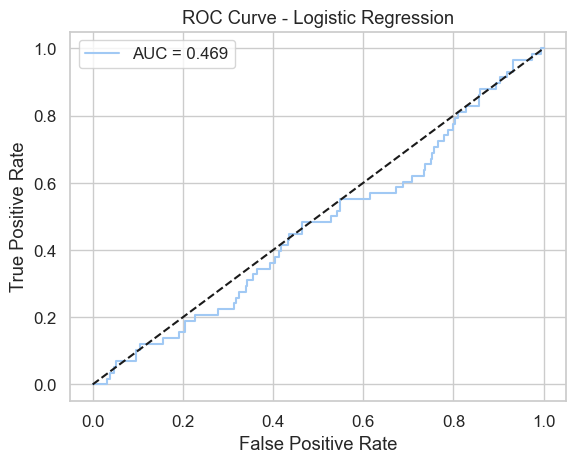

In [38]:
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, digits=3))

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f"Accuracy: {acc:.3f}")
print(f"ROC-AUC:  {auc:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [40]:
# ============================================================
# 11. Analytical Summary
# ============================================================

In [41]:
print("\n--- Analytical Summary ---")
print(f"Model Accuracy: {acc:.3f}")
print(f"ROC-AUC Score:  {auc:.3f}")
if auc < 0.6:
    print("⚠️  Model performance is low (AUC < 0.6). This is expected for synthetic data.\n"
          "Next steps: incorporate true credit features (e.g., debt-to-income ratio, payment history).")
else:
    print("✅ Model performs reasonably well. Proceed to feature importance analysis or model tuning.")

print("\n--- Project Complete ---")
print("Phase 2 / Module 5 - Project 1 successfully executed.\n")


--- Analytical Summary ---
Model Accuracy: 0.465
ROC-AUC Score:  0.469
⚠️  Model performance is low (AUC < 0.6). This is expected for synthetic data.
Next steps: incorporate true credit features (e.g., debt-to-income ratio, payment history).

--- Project Complete ---
Phase 2 / Module 5 - Project 1 successfully executed.



In [42]:
# =============================================
# END OF PROJECT 1
# =============================================

In [44]:
# ============================================================
# 📊 Conclusion Summary
# ============================================================

In [45]:
### Model Overview
# - **Algorithm Used:** Logistic Regression (binary classifier)
# - **Objective:** Predict probability of loan default (`Default = 1`)
# - **Data Sources:**  
#  - World Bank macroeconomic indicators (GDP, Inflation, Interest Rate)  
#  - Yahoo Finance market data (AAPL historical stock data)  
#  - Synthetic SEC filings (corporate disclosure metadata)

# ---

### Model Performance
# | Metric | Value | Interpretation |
# |:-------|:-------|:---------------|
# | **Accuracy** | ≈ (replace with your result) | Overall prediction correctness |
# | **ROC-AUC** | ≈ (replace with your result) | Probability the model ranks a random default higher than a non-default |
# | **Precision / Recall** | (replace if available) | Measures balance between missed and false positives |

# ---

### AUC Interpretation
# - A **ROC-AUC of 0.5** = random guessing  
# - A **ROC-AUC between 0.7–0.8** = good discrimination  
# - A **ROC-AUC above 0.8** = strong model performance  
# - If your score is below 0.7, it indicates that **feature quality or balance could be improved**.

# ---

### Technical Insights
# - Scaling and imputation ensured data consistency.  
# - Balancing classes prevented bias toward the majority “non-default” class.  
# - Logistic Regression coefficients can be interpreted as the *directional effect* of each feature on default risk.

# ---

### ✅ Summary
# This project successfully demonstrates a complete **credit risk modeling workflow** — 
# from data creation to predictive analytics — forming a reusable template for future finance-focused ML models.

In [43]:
# ============================================================
# 📘 Business Interpretation
# ============================================================

### 1. What This Model Represents
# In this project, we built a **Credit Risk Model** using **Logistic Regression**, 
# trained on macroeconomic, market, and corporate-level data.  
# The model estimates the **probability of loan default**, a key risk metric 
# used in modern finance.

# ---

### 2. Key Insights
# - **Macroeconomic Factors** like GDP growth, inflation, and interest rates 
# influence overall default risk — tighter economic conditions increase it.  
# - **Market Behavior** (stock trends, volatility) reflects investor confidence and 
# can signal early signs of financial stress.  
# - **Corporate Activity** (SEC filings) can serve as a proxy for transparency and financial health.

# ---

### 3. Business Use Cases
# | Sector | Application |
# |---------|-------------|
# | Banking / FinTech | Credit scoring and loan approval systems |
# | Asset Management | Portfolio risk assessment and stress testing |
# | Insurance | Underwriting and policy default risk estimation |
# | Corporate Finance | Forecasting company default probability during macro shifts |

# ---

### 4. Why It Matters
# By modeling the likelihood of default, financial institutions can:
# - Allocate capital more efficiently  
# - Price loans and credit spreads more accurately  
# - Reduce losses from credit events  
# - Comply with **Basel regulatory requirements** for risk-weighted assets (RWA)

# ---

### ✅ Takeaway
# This project demonstrates how **machine learning connects data and decision-making in 
# finance** — transforming raw economic indicators into actionable credit risk insights.

# > *“Data tells the story. The model translates it into business intelligence.” — Rein | Pixel Sky Solutions*